# The purpose of this notebook is to estimate dimensionality and scale using an MLE model. The MLE is based on Minka's paper "Automatic choice of dimensionality for PCA" (isotropic noise in a linear model).  We apply this MLE to noisy points from a sphere to see what happens.

In [1]:
import sys
sys.version

'2.7.12 |Anaconda 2.4.1 (x86_64)| (default, Jun 29 2016, 11:09:23) \n[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]'

In [2]:
## load trajectory data from file
import pickle

## diffusion maps
from diffusion_maps import run_diffusion_map
from diffusion_maps import make_gaussian_data

## numerical
import numpy as np
import random
import numpy.linalg as la
from scipy.linalg import eigh
from scipy.special import gammaln
from mpl_toolkits.mplot3d import Axes3D

%load_ext Cython
np.seterr(all='raise')

## plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.cm as cm

sys.path.append("/Users/gil/Documents/repos/cpp/vp_trees_cpp/vp_trees_cpp")
import vp_tree

## Functions for generating data, finding singular values.

In [3]:
def make_data(  N = 1000,
            dim = 100,
            k = 10,
            noise = 0.1,
         ):
    '''
    Data points on k dimensional sphere (S^k) in dim dimensional ambient space.
    N points, contaminated by Gaussian iid noise with sigma = 0.1.
    '''
    data = make_gaussian_data(0.,1.,N,k)
    data = [np.hstack([d/la.norm(d),np.zeros(dim-k)]) for d in data]
    data_corruption = np.asarray(make_gaussian_data(0.,noise,N,dim))
    data += data_corruption
    return data

In [4]:
def make_data_roll(H = 50., N = 5000, noise = 1e-1):
    '''
    Data points on k dimensional sphere (S^k) in dim dimensional ambient space.
    N points, contaminated by Gaussian iid noise with sigma = 0.1.
    '''
    dim = 3
    t = sorted([random.uniform(3.*np.pi/2., 9.*np.pi/2) for i in range(N)])
    h = [random.uniform(0,H) for i in range(N)]
    xs,ys,zs = list(t * np.cos(t)), list(h) , list(t * np.sin(t))
    data_corruption = np.asarray(make_gaussian_data(0.,noise,N,dim))
    return np.asarray(zip(xs,ys,zs)) + data_corruption

In [5]:
def make_data_spiral(H=50, L = 15, N = 1000, noise = 1e-2):
    dim = 3
    t = sorted([random.uniform(0, L*np.pi/2) for i in range(N)])
    xs,ys,zs = list(np.cos(t)), list(t), list(np.sin(t))
    data_corruption = np.asarray(make_gaussian_data(0.,noise,N,dim))
    return np.asarray(zip(xs,ys,zs)) + data_corruption

In [6]:
def make_into_arr(data):
    if type(data) != np.ndarray:
        if type(data) == list:
            data = np.asarray(data)
        else:
            raise ValueError("data should be numpy ndarray or list.")
    return data

In [7]:
def PCA_eigs(data):
    data = make_into_arr(data)
    mu = data.mean(axis=0,keepdims = True)
    data_centered = data - mu
    X = np.asmatrix(data_centered)
    Sigma = X.T*X/(dim-1)
    return la.eigvalsh(Sigma)[::-1]

In [10]:
def choose_random_neighborhood_points(data_list,sample_size = 40):
    '''
    pick sample_size points from data_list without replacement
    '''
    random_indices = np.random.choice(N,sample_size,replace=False)
    return [data_list[i] for i in random_indices]

## Assess dimensions with original scikit learn method, and Cythonized version.

In [11]:
def _assess_dimension_(spectrum, rank, n_samples, n_features):
    """Compute the likelihood of a rank ``rank`` dataset
    The dataset is assumed to be embedded in gaussian noise of shape(n,
    dimf) having spectrum ``spectrum``.
    Parameters
    ----------
    spectrum: array of shape (n)
        Data spectrum.
    rank: int
        Tested rank value.
    n_samples: int
        Number of samples.
    n_features: int
        Number of features.
    Returns
    -------
    ll: float,
        The log-likelihood
    Notes
    -----
    This implements the method of `Thomas P. Minka:
    Automatic Choice of Dimensionality for PCA. NIPS 2000: 598-604`
    """
    if rank > len(spectrum):
        raise ValueError("The tested rank cannot exceed the rank of the"
                         " dataset")

    pu = -rank * np.log(2.)
    for i in range(rank):
        pu += (gammaln((n_features - i) / 2.) -
               np.log(np.pi) * (n_features - i) / 2.)

    pl = np.sum(np.log(spectrum[:rank]))
    pl = -pl * n_samples / 2.

    if rank == n_features:
        pv = 0
        v = 1
    else:
        v = np.sum(spectrum[rank:]) / (n_features - rank)
        pv = -np.log(v) * n_samples * (n_features - rank) / 2.

    m = n_features * rank - rank * (rank + 1.) / 2.
    pp = np.log(2. * np.pi) * (m + rank + 1.) / 2.

    pa = 0.
    spectrum_ = spectrum.copy()
    spectrum_[rank:n_features] = v
    for i in range(rank):
        for j in range(i + 1, len(spectrum)):
            pa += np.log((spectrum[i] - spectrum[j]) *
                      (1. / spectrum_[j] - 1. / spectrum_[i])) + np.log(n_samples)

    ll = pu + pl + pv + pp - pa / 2. - rank * np.log(n_samples) / 2.

    return ll

In [12]:
%%cython

## From scikit-learn/sklearn/decomposition/pca.py, cythonized.

import numpy as np
from scipy.special import gammaln
from libc.math cimport log
from libc.math cimport M_PI

cpdef float _assess_dimension_c_(spectrum, int rank, int n_samples, int n_features):
    """Compute the likelihood of a rank ``rank`` dataset
    The dataset is assumed to be embedded in gaussian noise of shape(n,
    dimf) having spectrum ``spectrum``.
    Parameters
    ----------
    spectrum: array of shape (n)
        Data spectrum.
    rank: int
        Tested rank value.
    n_samples: int
        Number of samples.
    n_features: int
        Number of features.
    Returns
    -------
    ll: float,
        The log-likelihood
    Notes
    -----
    This implements the method of `Thomas P. Minka:
    Automatic Choice of Dimensionality for PCA. NIPS 2000: 598-604`
    """
    if rank > len(spectrum):
        raise ValueError("The tested rank cannot exceed the rank of the"
                         " dataset")
        
    cdef int i
    cdef int j 

    cdef float pu = -rank * log(2.)
    
    for i in range(rank):
        pu += (gammaln((n_features - i) / 2.) -
               log(M_PI) * (n_features - i) / 2.)

    cdef double pl = np.sum(np.log(spectrum[:rank]))
    pl = -pl * n_samples / 2.
    
    cdef float pv
    cdef float v

    if rank == n_features:
        pv = 0
        v = 1
    else:
        v = np.sum(spectrum[rank:]) / (n_features - rank)
        pv = -log(v) * n_samples * (n_features - rank) / 2.

    cdef float m = n_features * rank - rank * (rank + 1.) / 2.
    cdef float pp = log(2. * M_PI) * (m + rank + 1.) / 2.

    cdef double pa = 0.
    spectrum_ = spectrum.copy()
    spectrum_[rank:n_features] = v
    for i in range(rank):
        for j in range(i + 1, len(spectrum)):
            pa += log((spectrum[i] - spectrum[j]) *
                      (1. / spectrum_[j] - 1. / spectrum_[i])) + log(n_samples)
    
    return pu + pl + pv + pp - pa / 2. - rank * log(n_samples) / 2.

## Faster maximization for peaked dimensionality PDFs.

In [13]:
def find_max_over_ints(func,int_range):
    '''
    Find the argmax of func over a range of integers range(min_int,max_int).
    Assume that the function func has a peak. Before it is monotonically 
    increasing, and after it is monotonically decreasing.
    '''
    if not all ([type(val) == int for val in int_range]):
        raise ValueError("Must be ints")    
    
    return find_max_over_ints_helper(func,int_range)
    
def find_max_over_ints_helper(func,R):
    if len(R) == 0:
        return (None,None)
    elif len(R) == 1:
        return (R[0],func(R[0]))
    elif len(R) == 2:
        return max([(R[0],func(R[0])),(R[1],func(R[1]))],
                    key = lambda z: z[1])
    else: ## three or more
        Q = [R[int(len(R)/4)],R[int(len(R)/2)],R[int(len(R)*3/4)]]
        F = map(func,Q)
        if F[1] >= F[0] and F[1] >= F[2]:
            return find_max_over_ints_helper(func,np.arange(Q[0],Q[2]))
        elif F[0] >= F[1] >= F[2]:
            return find_max_over_ints_helper(func,np.arange(R[0],Q[1]+1))
        elif F[0] <= F[1] <= F[2]:
            return find_max_over_ints_helper(func,np.arange(Q[1],R[-1]+1))
        else:
            raise ValueError("The inputs violate the assumption that the function has a single peak.")

# Tests

## Values for tests

In [14]:
N = 1000
dim = 40
k = 10
noise = 0.1


## Generate data, find singular values.

In [15]:
data = make_data(N = N,
            dim = dim,
            k = k,
            noise = noise)

eigs = PCA_eigs(data)

## Naive maximization

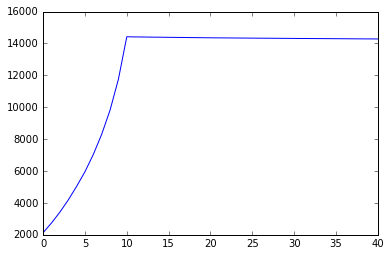

In [16]:
dims_mle = np.vectorize(lambda z: _assess_dimension_c_(eigs,z,N,dim))(np.arange(dim+1))
plt.plot(dims_mle)

## Fast maximization (peaked data), compare to naive maximization.

In [17]:
data = make_data(N = N,
            dim = dim,
            k = k,
            noise = noise)

eigs = PCA_eigs(data)

In [18]:
func = lambda z: _assess_dimension_c_(eigs,z,N,dim)

In [19]:
print find_max_over_ints(func,range(dim))[0]
print k

10
10


## Comments

When the intrinsic dimension and noise are not too high, we obtain a nice peaked function for which optimization to find the maximum can be done efficiently ($O(log(d))$ instead of $O(d)$ for the dimensionality $d$). However, when this breaks down the efficient strategy can no longer be used, in which case all possible dimensions must be checked. Further, when the noise levels become too high, the correct dimension becomes impossible to infer. 

## Different radii. Assume the singular values are the same throughout, sample them and average to do the analysis.

In [20]:
def sample_spectra(dim,rads,sample_points,tree,eigen_method = PCA_eigs):
    eig_sum = np.zeros((dim,len(rads)))
    num_sampled = np.zeros(len(rads))
    for x in sample_points:
        for i,eps in enumerate(rads):
            neighbors = tree.find_within_epsilon(x,eps)
            if len(neighbors) < dim + 2:
                pass
            else:
                num_sampled[i] += 1
                eig_sum[:,i] += PCA_eigs(neighbors)
    for i in range(len(rads)):
        if num_sampled[i] != 0:
            eig_sum[:,i] /= num_sampled[i]
    return eig_sum

In [21]:
def get_MLEs(dim,N,eig_sum,second_der = True):
    dims = np.zeros(len(eig_sum.T))
    dims_laplacian = np.zeros(len(eig_sum.T))
    for i,eigs in enumerate(eig_sum.T):
        if all ([el != 0 for el in eigs]):
            dims_mle = np.vectorize(lambda z: _assess_dimension_c_(eigs,z,N,dim))(np.arange(dim+1))

            ## second derivative
            if second_der:
                dims_mle_grad_der = dims_mle[1:] - dims_mle[:-1] 
                dims_mle_laplace = dims_mle_grad_der[1:] - dims_mle_grad_der[:-1]
                dims_laplacian[i] = np.argmax(abs(dims_mle_laplace))+1

            dims[i] = np.argmax(dims_mle)
    if second_der:
        return dims,dims_laplacian
    else:
        return dims

In [22]:
sample_size = 1

In [23]:
tree = vp_tree.tree_container(data.tolist())

In [27]:
data_list = data.tolist()

In [28]:
sample_points = choose_random_neighborhood_points(data_list,sample_size=sample_size)

In [29]:
rads = np.arange(1.5,2.5,0.01)

In [30]:
eig_sum = sample_spectra(dim,rads,sample_points,tree)

In [31]:
dims,dims_laplacian = get_MLEs(dim,N,eig_sum)

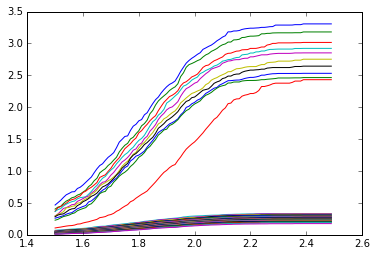

In [32]:
plt.plot(rads,eig_sum.T);

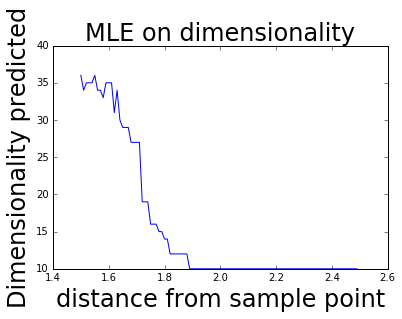

In [33]:
plt.plot(rads,dims)
plt.title("MLE on dimensionality",fontsize = 24)
plt.ylabel("Dimensionality predicted",fontsize = 24)
plt.xlabel("distance from sample point",fontsize = 24)

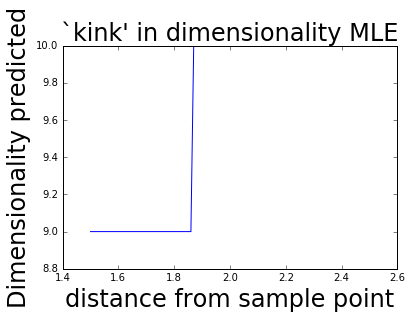

In [34]:
plt.plot(rads,dims_laplacian)
plt.title("`kink' in dimensionality MLE",fontsize = 24)
plt.ylabel("Dimensionality predicted",fontsize = 24)
plt.xlabel("distance from sample point",fontsize = 24)

## Comments

The MLE PDF generally has a kink, even when the maximum value lies elsewhere. Using the kink (i.e. maximizing a finite difference estimating the second derivative) seems to estimate the dimenaionlity much more cleanly than taking the argmax of the MLE.

## Another example, "swiss roll"

In [35]:
H = 50.
N = 2000
dim = 3
sample_size = 10

roll_data = make_data_roll(H=H, N = N)
tree = vp_tree.tree_container(roll_data.tolist())
sample_points = choose_random_neighborhood_points(data_list=roll_data.tolist(),sample_size=sample_size)

rads = np.arange(0,50,0.2)
eig_sum = sample_spectra(dim,rads,sample_points,tree)
dims,dims_laplacian = get_MLEs(dim,N,eig_sum)

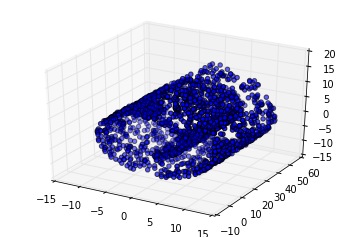

In [36]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(*roll_data.T)

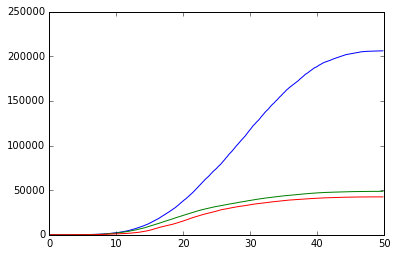

In [37]:
plt.plot(rads,eig_sum.T);

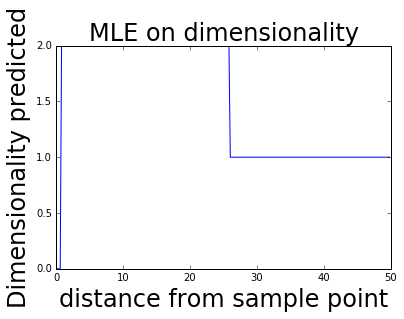

In [38]:
plt.plot(rads,dims)
plt.title("MLE on dimensionality",fontsize = 24)
plt.ylabel("Dimensionality predicted",fontsize = 24)
plt.xlabel("distance from sample point",fontsize = 24)

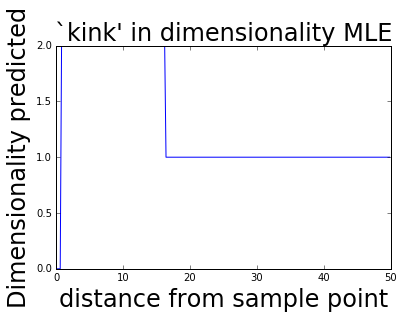

In [39]:
plt.plot(rads,dims_laplacian)
plt.title("`kink' in dimensionality MLE",fontsize = 24)
plt.ylabel("Dimensionality predicted",fontsize = 24)
plt.xlabel("distance from sample point",fontsize = 24)

## Another example, "Spiral"

In [40]:
H = 50.
N = 1000
L = 15
dim = 3
sample_size = 10

spiral_data = make_data_spiral(H=H,L=L, N = N, noise = 1e-2)
tree = vp_tree.tree_container(spiral_data.tolist())
sample_points = choose_random_neighborhood_points(data_list=spiral_data.tolist(),sample_size=sample_size)

rads = np.arange(0.01,1.,0.01)
eig_sum = sample_spectra(dim,rads,sample_points,tree)
dims,dims_laplacian = get_MLEs(dim,N,eig_sum)

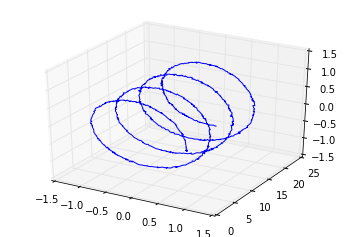

In [41]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(*spiral_data.T)

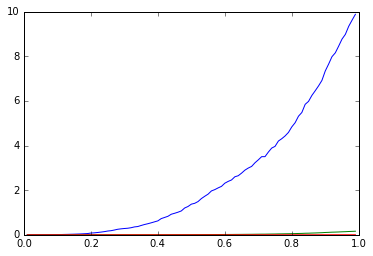

In [42]:
plt.plot(rads,eig_sum.T);

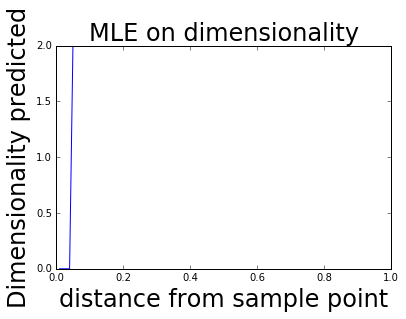

In [43]:
plt.plot(rads,dims)
plt.title("MLE on dimensionality",fontsize = 24)
plt.ylabel("Dimensionality predicted",fontsize = 24)
plt.xlabel("distance from sample point",fontsize = 24)

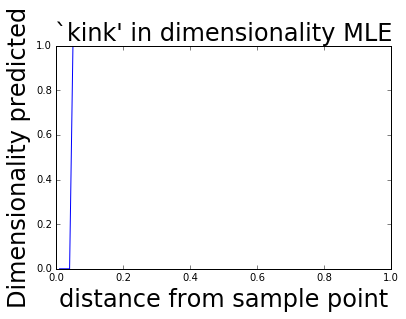

In [44]:
plt.plot(rads,dims_laplacian)
plt.title("`kink' in dimensionality MLE",fontsize = 24)
plt.ylabel("Dimensionality predicted",fontsize = 24)
plt.xlabel("distance from sample point",fontsize = 24)

## Comments:

I noticed above we need to add noise to the examples to get correct results. This is because without noise, the manifold is exactly smooth so the smallest eigenvalues are very close to zero. When this happens, the curvature singular values seem relatively larger to the MLE, so even with weak curvature their dimension is included. For example, in the spiral example without noise, singular values at around r = 0.1 might be for example around 1e-4,1e-7,1e-11. The first value is the true dimension, the second is curvature, the third is almost zero (due to curvature in the perpendicular direction). The MLE thinks the 1e-11 is noise since the MLE assumes a noisy model. As a result, the second singular value is thought to be a dimension. In most real examples, though, there will be noise. One possible fix is to add fictitious noise if none is present. Another strategy using the same MLE might be to append a method for finding the tiny singular values. Finally, another alternative is to use a different MLE, but this is more difficult because some other assumptions must be made about the noise, which may be artificial.

## Things to try next:

Instead of $\epsilon$ neighborhoods, maybe try neighborhoods with shortest consecutive distances.

Try ISOMAP for PCA

## Benchmarks

In [48]:
N = 1000
dim = 40
k = 10
noise = 0.1


data = make_data(N = N,
            dim = dim,
            k = k,
            noise = noise)

eigs = PCA_eigs(data)

In [49]:
## Original python code
%timeit dims_mle = np.vectorize(lambda z: _assess_dimension_(eigs,z,N,dim))(np.arange(dim+1))

10 loops, best of 3: 79.6 ms per loop


In [50]:
## Cythonized code
%timeit dims_mle = np.vectorize(lambda z: _assess_dimension_c_(eigs,z,N,dim))(np.arange(dim+1))

100 loops, best of 3: 10.5 ms per loop


In [55]:
## Optimized, assuming peaked data
%timeit find_max_over_ints(func,range(dim))

100 loops, best of 3: 2.99 ms per loop


## simple Cython tests...

In [56]:
%%cython

from libc.math cimport log
from scipy.special import gammaln

cpdef float f( float x):
    return gammaln(x)

In [57]:
from scipy.special import gammaln

In [58]:
%timeit f(5)

The slowest run took 29.51 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 953 ns per loop


In [59]:
%timeit gammaln(5)

The slowest run took 15.93 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 1.26 µs per loop
